In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/diegoloayza789/dataset/Grabacion-_14_.wav
/kaggle/input/datasets/diegoloayza789/dataset/norml.jpg
/kaggle/input/datasets/diegoloayza789/dataset/Symptoms2.wav
/kaggle/input/datasets/diegoloayza789/dataset/Symptoms.wav
/kaggle/input/datasets/diegoloayza789/dataset/nea.png
/kaggle/input/datasets/diegoloayza789/dataset/nue2.jpg
/kaggle/input/datasets/diegoloayza789/dataset/neuom.jpeg
/kaggle/input/datasets/diegoloayza789/final-dataset/neumonia2.png
/kaggle/input/datasets/diegoloayza789/final-dataset/artrosis1.png
/kaggle/input/datasets/diegoloayza789/final-dataset/Neumonia2.wav
/kaggle/input/datasets/diegoloayza789/final-dataset/tumorcerebral2.png
/kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg
/kaggle/input/datasets/diegoloayza789/final-dataset/artrosis2.png
/kaggle/input/datasets/diegoloayza789/final-dataset/cancerpulmon1.jpg
/kaggle/input/datasets/diegoloayza789/final-dataset/Melanoma1.wav
/kaggle/input/datasets/diegoloayza789/final-dataset/neumo

In [2]:
! uv pip install accelerate bitsandbytes git+https://github.com/huggingface/transformers.git@65dc261512cbdb1ee72b88ae5b222f2605aad8e5 levenshtein jiwer librosa

Using Python 3.12.12 environment at: /usr
Resolved 71 packages in 49ms                                         
Audited 71 packages in 1ms


In [126]:
 pip install -U bitsandbytes>=0.46.1

Note: you may need to restart the kernel to use updated packages.


In [15]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --force-reinstall

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [33]:
import os
import sys

# Local setup for Hugging Face authentication
from huggingface_hub import get_token
if get_token() is None:
    print("Logging in to Hugging Face...")
    from huggingface_hub import notebook_login
    notebook_login()
else:
    os.environ["HF_TOKEN"] = get_token()
    print("Token obtenido")

Token obtenido


In [22]:
from transformers import AutoModelForImageTextToText, AutoProcessor, pipeline, BitsAndBytesConfig
import torch

MODEL_MEDGEMMA = "google/medgemma-1.5-4b-it"
MODEL_MEDASR = "google/medasr"
print("⏳ Cargando el modelo base en la GPU (Solo una vez)...")

# 1. Cargamos el procesador (maneja texto e imágenes) y el modelo UNA SOLA VEZ
processor = AutoProcessor.from_pretrained(MODEL_MEDGEMMA)

# Cargamos el modelo base cuantizado para que ocupe muy poca VRAM
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

modelo_base = AutoModelForImageTextToText.from_pretrained(
    MODEL_MEDGEMMA,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map="auto"
)
print("✅ Modelo base cargado en memoria.")

# MedGemma Images
try:
    med_image_pipe = pipeline(
        "image-text-to-text",
        model=modelo_base,       # Le pasamos el objeto, no el texto
        processor=processor
    )
    print("✅ Pipeline multimodal (Imagen+Texto) listo.")
except Exception as e:
    print(f"❌ Error en pipeline de imagen: {e}")

# MedGemma text
try:
    med_text_pipe = pipeline(
        "text-generation", 
        model=modelo_base,       # Reutilizamos exactamente el mismo objeto
        tokenizer=processor.tokenizer
    )
    print("✅ Pipeline de texto puro listo.")
except Exception as e:
    print(f"❌ Error en pipeline de texto: {e}")

# Medasr
try:
    medasr_pipe = pipeline(
        "automatic-speech-recognition", 
        model=MODEL_MEDASR)
    print("✅ MedAsr cargado.")
except Exception as e:
    print(f"❌ Error cargando MedASR: {e}")


⏳ Cargando el modelo base en la GPU (Solo una vez)...


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

✅ Modelo base cargado en memoria.
✅ Pipeline multimodal (Imagen+Texto) listo.
✅ Pipeline de texto puro listo.


Loading weights:   0%|          | 0/368 [00:00<?, ?it/s]

✅ MedAsr cargado.


In [10]:
import os
from PIL import Image
from IPython.display import Image as IPImage, display, Markdown
image = "/kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg"
# prompt = "Describe this X-ray" 
prompt = """Describe this medical image. 
You must strictly follow this output format:
1. Provide your detailed anatomical observations.
2. You MUST include a section titled exactly '[IRREGULARITIES]' followed by a explanation of the irregularities in the image
3. At the very end of your response, you MUST include a section titled exactly '[PATHOLOGIES]'a comma-separated list of the top 1 to 3 possible diseases or conditions.
Example:
[OBSERVATIONS] The image is a lateral view of a human left femur
[IRREGULARITIES] The lesion exhibits irregular borders and uneven coloration
[PATHOLOGIES] Pneumonia, Lung Mass, Tuberculosis
"""
role_instruction = "You are an expert in multidisciplinary diagnostic imaging."

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": role_instruction}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

output = med_image_pipe(text=messages, max_new_tokens=1500, do_sample=False)
response = output[0]["generated_text"][-1]["content"]
Pre_diagnosis_image = "[OBSERVATIONS]" + response.split("[OBSERVATIONS]")[-1]
# display(Markdown(f"---\n\n**[ User ]**\n\n{prompt}"))
# # display(IPImage(filename=image_filename, height=300))
# display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{response}\n\n---"))
print(Pre_diagnosis_image)


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


[OBSERVATIONS] The image is a close-up view of human skin featuring a pigmented lesion. The lesion is roughly oval-shaped and located centrally within the frame. It is situated on lighter-toned skin which shows some fine texture and lines.[IRREGULARITIES] The lesion exhibits several features suggestive of potential concern:***Asymmetry:** The shape is not perfectly symmetrical.***Border:** The borders appear somewhat irregular and not sharply defined in all areas.***Color:** The coloration is variegated, displaying multiple shades including light brown, dark brown, and black, possibly with some reddish/purplish tones.***Surface:** The surface texture appears slightly uneven.[PATHOLOGIES] Melanoma, Atypical Nevus


In [43]:
import librosa
def transcribir_audio(ruta_audio):
    speech_array, sampling_rate = librosa.load(ruta_audio, sr=16000)
    # Pasamos el audio ya cargado como un diccionario de datos 'raw'
    result = medasr_pipe({"raw": speech_array, "sampling_rate": sampling_rate}, chunk_length_s=20, stride_length_s=2)
    
    # print(result)
    texto_transcrito = result['text']
    # 2. Limpiamos el token '</s>' y espacios extra
    texto_limpio = texto_transcrito.replace('</s>', '').strip()
    return texto_limpio
    
mi_audio = "/kaggle/input/datasets/diegoloayza789/final-dataset/Melanoma1.wav"
initial_symptoms = transcribir_audio(mi_audio)

print(initial_symptoms)

I got this mole on my shoulder for a few years, but recently it started itching a lot. I also noticed it looks bigger and the edges are kind blurry now. It is not just brown anymore. It has some black and reddish spots in it. It even bled a tiny bit on my shrt yesterday when I was getting dressed.


In [45]:
SYSTEM_PROMPT = """You are an automated clinical triage assistant. Your role is to act as a structured intermediary between the patient and the human doctor.
Your goal is to ask precise questions to narrow down symptoms and generate a short differential pre-diagnosis that will later be reviewed by the doctor.

STRICT OPERATING RULES:
1. EVALUATION: You will receive the patient's symptoms, objective image irregularities, and a list of 'Suggested Pathologies' from a radiologist AI. Your primary task is to ask targeted questions to differentiate, rule in, or rule out these specific pathologies.
2. FORMAT RESTRICTION: Every question MUST be strictly multiple-choice, with a maximum of 5 options (letters A, B, C, D, E).
3. THE LAST OPTION: The last letter of your options MUST ALWAYS be: "None of the above".
4. QUESTION LIMIT: You must never exceed a maximum of 7 questions throughout the triage.
5. ACTION TAGS:
   - To ask, use EXACTLY: [ASK]
   - To give the result, use EXACTLY: [DIAGNOSIS]

STRICT FORMAT FOR ASKING:
[ASK] [Write your clinical question here]?
A) [Specific option 1]
B) [Specific option 2]
C) [Specific option 3]
D) [Specific option 4]
E) None of the above

STRICT FORMAT FOR THE PRE-DIAGNOSIS:
[DIAGNOSIS]
* Ranked Pre-diagnosis: 
  1. [Most Probable Illness] - [Brief reason why it's the top match based on symptoms/imaging]
  2. [Less Probable Illness] - [Brief reason why it's less likely]
  3. [Least Probable Illness] - [Brief reason why it's the least likely or what symptom is missing]
  (Note: Adjust numbering based on the number of suspected conditions provided by the radiologist).
* Clinical summary (Symptoms + Imaging): [Brief summary cross-referencing what the patient said and what the imaging showed]
* Suggested urgency level: [Low / Medium / High]
* Note: This is an AI-generated pre-diagnosis that requires mandatory validation by a human doctor.
"""

# Initialize memory
history = [
    {"role": "user", "content": SYSTEM_PROMPT},
    {"role": "assistant", "content": "Understood. I am ready to evaluate the patient."}
]
final_diagnosis = ""

print("🤖 Starting Intelligent Medical Triage (Multimodal)")
print("=" * 60)

# ---------------------------------------------------------
# PHASE 1: INITIAL INPUT & ROBUST PARSING
# ---------------------------------------------------------
initial_symptoms = initial_symptoms
findings = Pre_diagnosis_image

print("Initial symptoms: " + initial_symptoms)
print("Image results:" + findings)

# Variables para guardar los textos limpios
obs_text = ""
irreg_text = ""
path_text = ""

# Parser robusto para las 3 etiquetas
try:
    if "[OBSERVATIONS]" in findings and "[IRREGULARITIES]" in findings and "[PATHOLOGIES]" in findings:
        # Cortamos el texto en bloques lógicos
        part1 = findings.split("[IRREGULARITIES]")
        obs_text = part1[0].replace("[OBSERVATIONS]", "").strip()
        
        part2 = part1[1].split("[PATHOLOGIES]")
        irreg_text = part2[0].strip()
        path_text = part2[1].strip()
    else:
        # Fallback de seguridad si falta alguna etiqueta
        obs_text = "See raw findings."
        irreg_text = findings
        path_text = "No structured pathologies provided."
except Exception as e:
    obs_text = "Parsing error."
    irreg_text = findings
    path_text = "Error extracting pathologies."

# Empaquetamos todo con una estructura impecable para MedGemma
initial_message = f"""
--- INITIAL PATIENT DATA ---

1. REPORTED SYMPTOMS (Subjective):
{initial_symptoms}

2. GENERAL IMAGE OBSERVATIONS:
{obs_text}

3. SPECIFIC IMAGE IRREGULARITIES:
{irreg_text}

4. RADIOLOGIST'S SUGGESTED PATHOLOGIES:
{path_text}
------------------------------------
Please act as the triage doctor. Analyze this cross-referenced data and begin the triage to differentiate the suggested pathologies.
"""

print("\n👉 Registering parsed history and imaging in the system...")
history.append({"role": "user", "content": initial_message})

QUESTION_LIMIT = 7 
question_counter = 0

# ---------------------------------------------------------
# PHASE 2: QUESTION CYCLE (THE PYTHON ARBITER)
# ---------------------------------------------------------
while True:
    print("\n🧠 MedGemma is analyzing the case...")
    
    # 1. Execute the model
    output = med_text_pipe(
        history, 
        max_new_tokens=1500, 
        repetition_penalty=1.15
    )
    
    raw_text = output[0]["generated_text"][-1]["content"]
    
    # 2. Look for the final decision (ignoring inner thoughts)
    pos_diag = raw_text.rfind("[DIAGNOSIS]")
    pos_ask = raw_text.rfind("[ASK]")
    
    if pos_diag > pos_ask:
        clean_response = raw_text[pos_diag:]

        final_diagnosis = clean_response.replace('[DIAGNOSIS]', '').strip()
        
        print("\n" + "=" * 60)
        print(f"🚨 PRELIMINARY DIAGNOSIS REACHED:\n{final_diagnosis}")
        print("=" * 60)
        print("\nReferring to a human doctor... End of triage.")
        break 
        
    elif pos_ask > pos_diag:
        question_counter += 1 
        
        # --- PYTHON ARBITER IN ACTION ---
        if question_counter > QUESTION_LIMIT:
            print(f"\n⚠️ The maximum limit of {QUESTION_LIMIT} questions was reached.")
            print("Forcing MedGemma to issue the diagnosis...")
            
            history[-1]["content"] += "\n\n[SYSTEM INSTRUCTION]: You have reached the question limit. Issue EXACTLY the final [DIAGNOSIS] format right now based on the information you have. DO NOT ask more questions."
            continue 
        
        clean_response = raw_text[pos_ask:]
        history.append({"role": "assistant", "content": clean_response})
        
        display_question = clean_response.replace("[ASK]", "").strip()
        print(f"\n🩺 AI Agent asks (Question {question_counter}/{QUESTION_LIMIT}):\n{display_question}")
        
        patient_response = input("\n⌨️ Choose an option (A, B, C, D, E) or type 'exit': ")
        
        if patient_response.lower() == 'exit':
            print("Session canceled by the user.")
            break
            
        enriched_response = f"The patient chose option: {patient_response}"
        history.append({"role": "user", "content": enriched_response})
        
    else:
        print("\n⚠️ The model did not use any valid tag. Raw text:")
        print(raw_text)
        break

🤖 Starting Intelligent Medical Triage (Multimodal)
Initial symptoms: I got this mole on my shoulder for a few years, but recently it started itching a lot. I also noticed it looks bigger and the edges are kind blurry now. It is not just brown anymore. It has some black and reddish spots in it. It even bled a tiny bit on my shrt yesterday when I was getting dressed.
Image results:[OBSERVATIONS] The image is a close-up view of human skin featuring a pigmented lesion. The lesion is roughly oval-shaped and located centrally within the frame. It is situated on lighter-toned skin which shows some fine texture and lines.[IRREGULARITIES] The lesion exhibits several features suggestive of potential concern:***Asymmetry:** The shape is not perfectly symmetrical.***Border:** The borders appear somewhat irregular and not sharply defined in all areas.***Color:** The coloration is variegated, displaying multiple shades including light brown, dark brown, and black, possibly with some reddish/purplish


⌨️ Choose an option (A, B, C, D, E) or type 'exit':  B



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 2/7):
How long has the patient had this particular mole before they first noticed the itching and changes?A) Less than 6 months ago.B) Between 6 months and 1 year ago.C) More than 1 year ago.D) I don't remember exactly, it's been there a while.E) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  A



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 3/7):
Since you first noticed the changes, can you describe how much the size of the mole has increased?A) It hasn't significantly increased in size.B) It has increased noticeably in size.C) I haven't measured it, but I feel it's bigger.D) It has decreased in size.E) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  C



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 4/7):
Have you ever experienced bleeding or oozing from this mole before?A) Yes, I have bled or oozed from this mole before.B) No, I have not bled or oozed from this mole.C) Only once, maybe more than a year ago.D) Yes, I have bled or oozed from this mole multiple times since noticing the changes.E) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  A



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 5/7):
Has the patient performed any self-examination or biopsy procedures related to this mole?A) Yes, I have done a self-exam and potentially a biopsy at home.B) No, I have not performed any self-exams beyond looking closely.C) Yes, I have undergone a professional medical evaluation, including a biopsy if possible.D) No, I have not performed any biopsies professionally.E) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  B



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 6/7):
Has the patient had any recent changes in their lifestyle, such as sun exposure, stress levels, weight change, or starting new medications?A) Yes, I have significantly increased my sun exposure lately.B) No, my lifestyle factors have remained consistent.C) Yes, I have experienced significant stress over the past month.D) Yes, I have lost considerable weight recently.E) Yes, I have started taking a new medication recently.F) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  A



🧠 MedGemma is analyzing the case...

🩺 AI Agent asks (Question 7/7):
Does the patient have any personal history of melanoma or atypical nevi?A) Yes, I have personally diagnosed myself with melanoma.B) No, I do not have a known history of melanoma.C) Yes, I have previously been told I have atypical nevus by a doctor.D) Yes, I have personally diagnosed myself with atypical nevus.E) None of the above



⌨️ Choose an option (A, B, C, D, E) or type 'exit':  B



🧠 MedGemma is analyzing the case...

⚠️ The maximum limit of 7 questions was reached.
Forcing MedGemma to issue the diagnosis...

🧠 MedGemma is analyzing the case...

🚨 PRELIMINARY DIAGNOSIS REACHED:
* Ranked Pre-diagnosis:1. Melanoma - Several concerning features align with melanoma (asymmetry, irregular borders, color variation, diameter increase, evolution via itching/bleeding).2. Atypical Nevus - Shares features with melanoma, and is a possibility though perhaps less likely given the rapid progression (itching/bleeding).3. Common Nevus - Unlikely given the marked changes and concerning features.* Clinical summary (Symptoms + Imaging): Review of a solitary pigmented lesion observed for years, exhibiting recent significant changes including itching, size increase, altered appearance (non-brown color), and minor bleeding. Imaging confirms features highly suspicious for malignancy (Asymmetry, Border irregularity, Color variegation, Uneven surface).* Suggested urgency level: High.* Not

In [46]:
print(final_diagnosis)

* Ranked Pre-diagnosis:1. Melanoma - Several concerning features align with melanoma (asymmetry, irregular borders, color variation, diameter increase, evolution via itching/bleeding).2. Atypical Nevus - Shares features with melanoma, and is a possibility though perhaps less likely given the rapid progression (itching/bleeding).3. Common Nevus - Unlikely given the marked changes and concerning features.* Clinical summary (Symptoms + Imaging): Review of a solitary pigmented lesion observed for years, exhibiting recent significant changes including itching, size increase, altered appearance (non-brown color), and minor bleeding. Imaging confirms features highly suspicious for malignancy (Asymmetry, Border irregularity, Color variegation, Uneven surface).* Suggested urgency level: High.* Note: This is an AI-generated pre-diagnosis that requires mandatory validation by a human doctor.


In [47]:
# initial_symptoms, obs_text, irreg_text, final_diagnosis
nombre_imagen = image

reporte_soap = f"""
==================================================
        REPORTE CLÍNICO DE TRIAJE (SOAP)
==================================================

[ S ] - SUBJETIVO (Reporte del Paciente)
--------------------------------------------------
{initial_symptoms}

[ O ] - OBJETIVO (Hallazgos de Imagen Automatizados)
--------------------------------------------------
* Archivo Analizado: {nombre_imagen}
* Observaciones: {obs_text}
* Irregularidades: {irreg_text}

[ A ] - ANÁLISIS (Pre-diagnóstico MedGemma)
--------------------------------------------------
{final_diagnosis}

[ P ] - PLAN (Acciones Sugeridas)
--------------------------------------------------
* Derivar a especialista para validación médica obligatoria.
* Adjuntar historial de triaje y archivo fotográfico ({nombre_imagen}) al expediente.

==================================================
"""

print(reporte_soap)


        REPORTE CLÍNICO DE TRIAJE (SOAP)

[ S ] - SUBJETIVO (Reporte del Paciente)
--------------------------------------------------
I got this mole on my shoulder for a few years, but recently it started itching a lot. I also noticed it looks bigger and the edges are kind blurry now. It is not just brown anymore. It has some black and reddish spots in it. It even bled a tiny bit on my shrt yesterday when I was getting dressed.

[ O ] - OBJETIVO (Hallazgos de Imagen Automatizados)
--------------------------------------------------
* Archivo Analizado: /kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg
* Observaciones: The image is a close-up view of human skin featuring a pigmented lesion. The lesion is roughly oval-shaped and located centrally within the frame. It is situated on lighter-toned skin which shows some fine texture and lines.
* Irregularidades: The lesion exhibits several features suggestive of potential concern:***Asymmetry:** The shape is not perfectly s

In [52]:
from PIL import Image
from IPython.display import Image as IPImage, display, Markdown

nombre_imagen = image

reporte_soap_md = f"""# 🏥 Automated Clinical Triage Report (SOAP)

---

## 🗣️ [S] Subjective (Patient Report)
**Patient's Initial Symptoms:**
> *"{initial_symptoms}"*

## 📸 [O] Objective (Automated Image Findings)
**Attached Media:** `{nombre_imagen}`

**General Observations:**
{obs_text}

**Specific Irregularities:**
{irreg_text}

## 🧠 [A] Assessment (AI Pre-Diagnosis)
{final_diagnosis}

## 📋 [P] Plan (Next Steps)
* **Action Required:** Immediate referral for in-person clinical validation by a specialist (Dermatologist).
* **Documentation:** Attach this triage history and the image file (`{nombre_imagen}`) to the patient's electronic health record.
* **Disclaimer:** *This is an AI-generated triage report and requires mandatory validation by a qualified human doctor.*
"""

display(Markdown((reporte_soap_md)))

# 🏥 Automated Clinical Triage Report (SOAP)

---

## 🗣️ [S] Subjective (Patient Report)
**Patient's Initial Symptoms:**
> *"I got this mole on my shoulder for a few years, but recently it started itching a lot. I also noticed it looks bigger and the edges are kind blurry now. It is not just brown anymore. It has some black and reddish spots in it. It even bled a tiny bit on my shrt yesterday when I was getting dressed."*

## 📸 [O] Objective (Automated Image Findings)
**Attached Media:** `/kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg`

**General Observations:**
The image is a close-up view of human skin featuring a pigmented lesion. The lesion is roughly oval-shaped and located centrally within the frame. It is situated on lighter-toned skin which shows some fine texture and lines.

**Specific Irregularities:**
The lesion exhibits several features suggestive of potential concern:***Asymmetry:** The shape is not perfectly symmetrical.***Border:** The borders appear somewhat irregular and not sharply defined in all areas.***Color:** The coloration is variegated, displaying multiple shades including light brown, dark brown, and black, possibly with some reddish/purplish tones.***Surface:** The surface texture appears slightly uneven.

## 🧠 [A] Assessment (AI Pre-Diagnosis)
* Ranked Pre-diagnosis:1. Melanoma - Several concerning features align with melanoma (asymmetry, irregular borders, color variation, diameter increase, evolution via itching/bleeding).2. Atypical Nevus - Shares features with melanoma, and is a possibility though perhaps less likely given the rapid progression (itching/bleeding).3. Common Nevus - Unlikely given the marked changes and concerning features.* Clinical summary (Symptoms + Imaging): Review of a solitary pigmented lesion observed for years, exhibiting recent significant changes including itching, size increase, altered appearance (non-brown color), and minor bleeding. Imaging confirms features highly suspicious for malignancy (Asymmetry, Border irregularity, Color variegation, Uneven surface).* Suggested urgency level: High.* Note: This is an AI-generated pre-diagnosis that requires mandatory validation by a human doctor.

## 📋 [P] Plan (Next Steps)
* **Action Required:** Immediate referral for in-person clinical validation by a specialist (Dermatologist).
* **Documentation:** Attach this triage history and the image file (`/kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg`) to the patient's electronic health record.
* **Disclaimer:** *This is an AI-generated triage report and requires mandatory validation by a qualified human doctor.*


# 🏥 Automated Clinical Triage Report (SOAP)

---

## 🗣️ [S] Subjective
**Chief Complaint & History of Present Illness:**
> *"I got this mole on my shoulder for a few years, but recently it started itching a lot. I also noticed it looks bigger and the edges are kind blurry now. It is not just brown anymore. It has some black and reddish spots in it. It even bled a tiny bit on my shrt yesterday when I was getting dressed."*

## 📸 [O] Objective
**Attached Media:** <br>
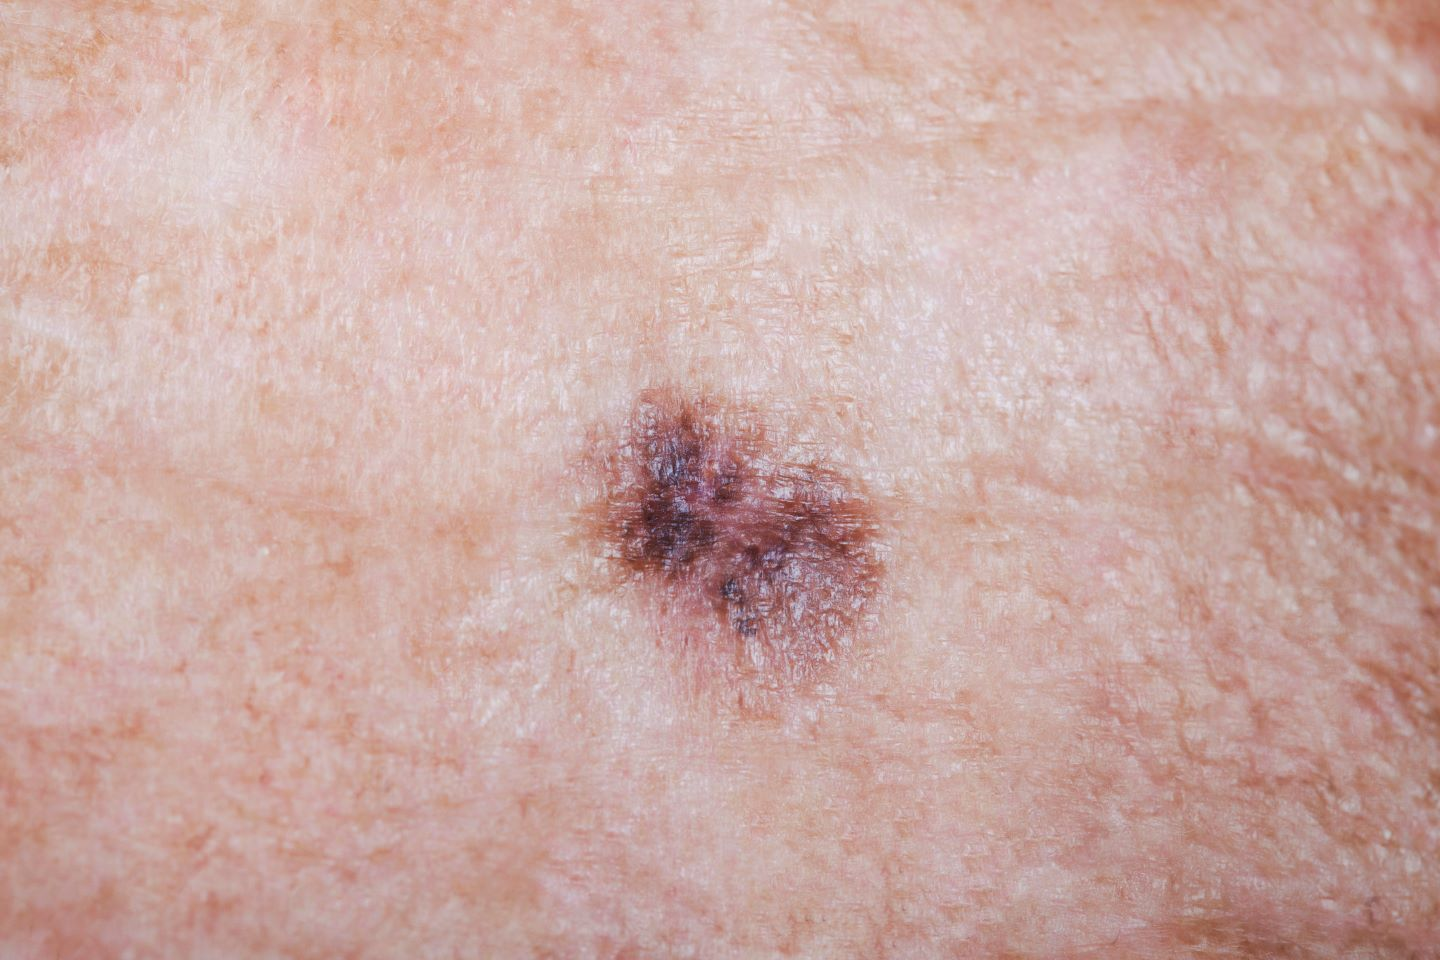

**General Image Observations:**
The image is a close-up view of human skin featuring a pigmented lesion. The lesion is roughly oval-shaped and located centrally within the frame. It is situated on lighter-toned skin which shows some fine texture and lines.

**Specific Irregularities:**
The lesion exhibits several features suggestive of potential concern:**
* Asymmetry:** The shape is not perfectly symmetrical.**
* Border:** The borders appear somewhat irregular and not sharply defined in all areas.**
* Color:** The coloration is variegated, displaying multiple shades including light brown, dark brown, and black, possibly with some reddish/purplish tones.**
* Surface:** The surface texture appears slightly uneven.

## 🧠 [A] Assessment


*  Ranked Pre-diagnosis:
   1. Melanoma - Several concerning features align with melanoma (asymmetry, irregular borders, color variation, diameter increase, evolution via itching/bleeding).
   2. Atypical Nevus - Shares features with melanoma, and is a possibility though perhaps less likely given the rapid progression (itching/bleeding).
   3. Common Nevus - Unlikely given the marked changes and concerning features.

*  Clinical summary (Symptoms + Imaging): Review of a solitary pigmented lesion observed for years, exhibiting recent significant changes including itching, size increase, altered appearance (non-brown color), and minor bleeding. Imaging confirms features highly suspicious for malignancy (Asymmetry, Border irregularity, Color variegation, Uneven surface).

*  Suggested urgency level: High.

*  Note: This is an AI-generated pre-diagnosis that requires mandatory validation by a human doctor.

## 📋 [P] Plan
* **Action Required:** Immediate referral for in-person clinical validation by a specialist (Dermatology).
* **Documentation:** Attach this triage history and the image file (`/kaggle/input/datasets/diegoloayza789/final-dataset/melanoma2.jpg`) to the patient's electronic health record.
* **Disclaimer:** *This is an AI-generated triage report and requires mandatory validation by a qualified human doctor.*


In [145]:
import re
import base64
from IPython.display import display, Markdown
import os
nombre_imagen = image

# 2. Función para convertir la imagen a Base64
def obtener_imagen_base64(ruta_imagen):
    if os.path.exists(ruta_imagen):
        with open(ruta_imagen, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode()
        # Creamos el string que HTML entiende
        return f"data:image/jpeg;base64,{encoded_string}"
    else:
        return "" # Si no encuentra la imagen, no crashea

img_src_b64 = obtener_imagen_base64(nombre_imagen)

# 3. Tu código de limpieza (Regex)
irreg_text_limpio = re.sub(r'\*(?=[a-zA-Z])', '\n* ', irreg_text)
irreg_text_limpio = irreg_text_limpio.replace("***", "\n* **") 
final_diagnosis_limpio = final_diagnosis.replace("*", "\n\n* ")
final_diagnosis_limpio = re.sub(r'(?<!\n)(\d+\.)', r'\n   \1', final_diagnosis_limpio)

# 4. Construir el reporte inyectando la imagen en Base64
reporte_soap_md = f"""# 🏥 Automated Clinical Triage Report (SOAP)

---

## 🗣️ [S] Subjective
**Chief Complaint & History of Present Illness:**
> *"{initial_symptoms}"*

## 📸 [O] Objective
**Attached Media:** <br>
<img src="{img_src_b64}" alt="Imagen Clínica" width="400" style="border-radius: 8px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);"/>

**General Image Observations:**
{obs_text}

**Specific Irregularities:**
{irreg_text_limpio}

## 🧠 [A] Assessment
{final_diagnosis_limpio}

## 📋 [P] Plan
* **Action Required:** Immediate referral for in-person clinical validation by a specialist (Dermatology).
* **Documentation:** Attach this triage history and the image file (`{nombre_imagen}`) to the patient's electronic health record.
* **Disclaimer:** *This is an AI-generated triage report and requires mandatory validation by a qualified human doctor.*
"""

display(Markdown(reporte_soap_md))